# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2023/24 (6 CFU) - Dr. Jacopo Pegoraro, Dr. Daniele Mari, Dr. Riccardo Mazzieri
---


## Supplementary  material - Neural network manual implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# manual implementation: no torch required!

# Theoretical Background

### Artificial Neuron

This is the structure of a single artificial neuron

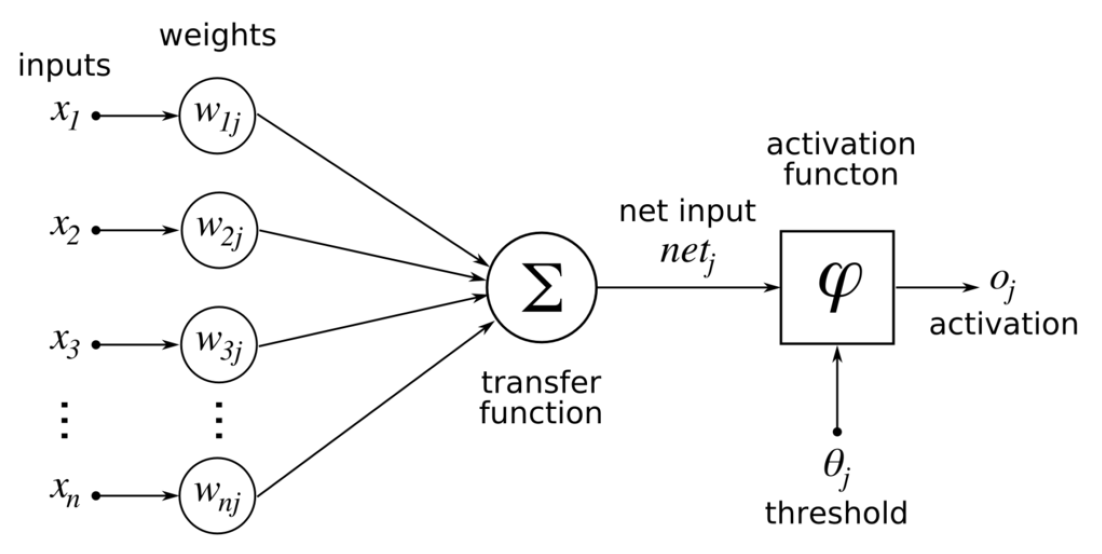

### Fully connected feed-forward network

A neural network is composed by several artificial neurons, typically organized in layers and connected in different ways. One of the most common neural network is the **fully-connected feed-forward network**, where each neuron is connected to all the neurons of the previous layer. The first layer takes the feature vector as input, and the number of outputs is defined by the number of neurons in the last layer.

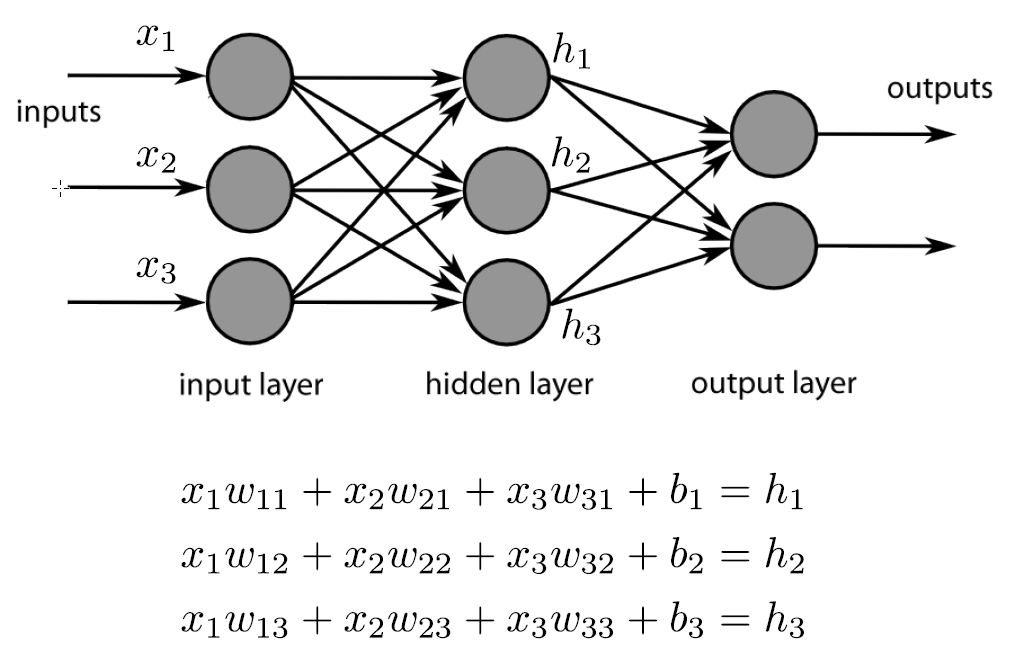

All the linear computation of a single layer (without considering the activation function) can be simply expressed in a matrix form, as follows:

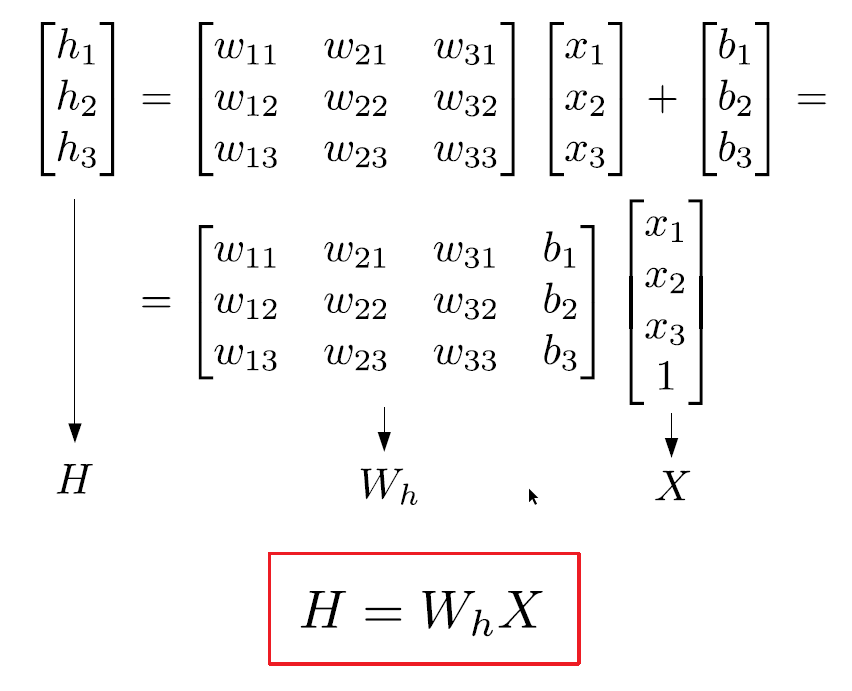

When we include the activation function and we consider more than one layer (2 hidden layers in this example) we still have a quite simple expression for the entire network. $X$ is the input vector, $H_n$ are the linear activations, $Z_n$ are the non-linear activations, and $Y$ is the output.

The computation of this equation is typically referred to as *forward-pass*.

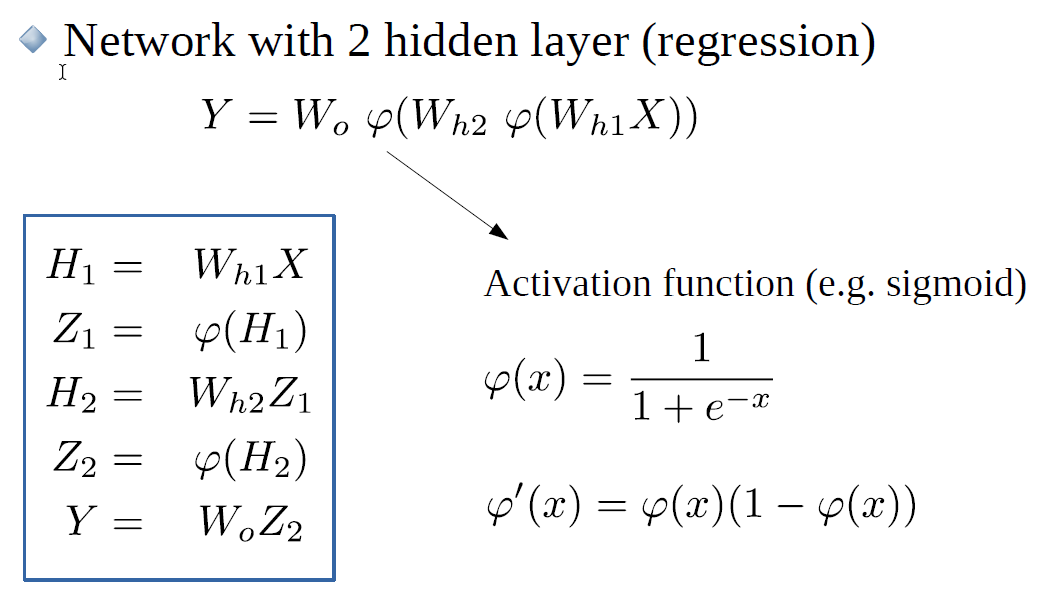

### Gradient Descent

When we use a neural network for a regression or classification problem, we compare the output the network with the actual values given by a training set.

This comparison is quantified by a **loss function**. In this case we consider a Mean Square Error (MSE) function, analogously to the least square problem analyzed in the previous lab.

The main goal is to find a set of parameters $W$ that minimizes the loss function. The rationale behind the **gradient descent** algorithm is to slighlty update the values of the weights depending on their gradient wrt the loss function. The update is repeated until we reach a stopping criteria, e.g. the training loss is not decreasing anymore, or the loss function evaluated on the validation set (**validation loss**) starts to increase (**overfitting**).

It is clear that the main point here is to evaluate the gradient of the weights wrt the loss function. Starting from the output layer, and thanks to the **chain rule**, we can easily leverage previously evaluated gradients to simplify the computation (**back-propagation**).

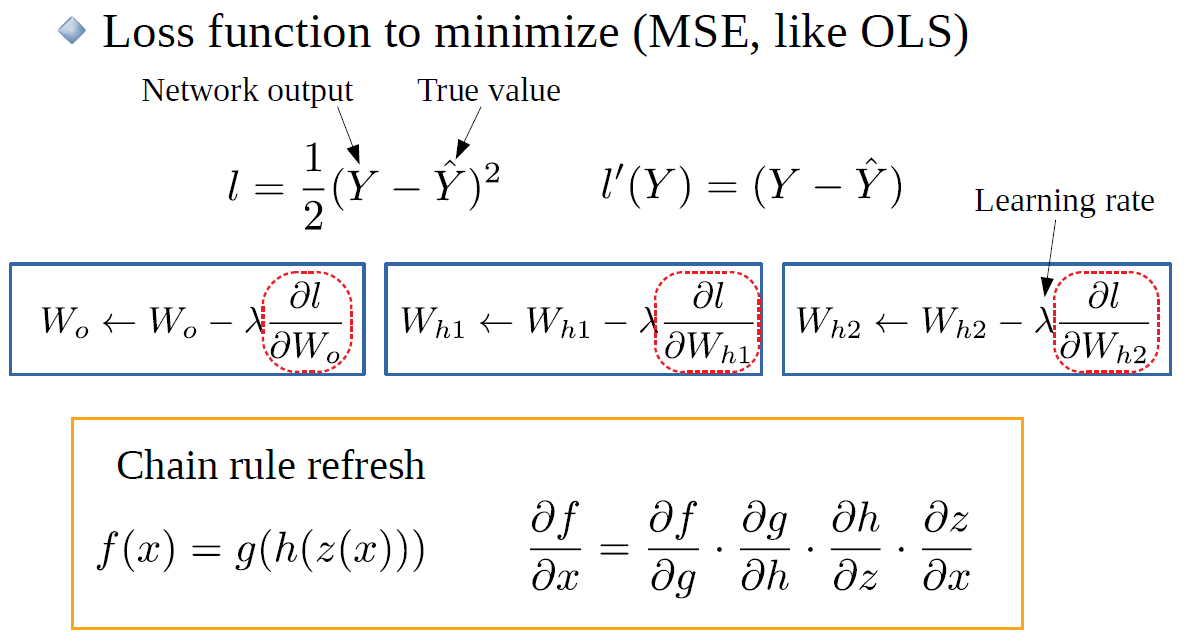

If you apply the chain rule, as you cas see below, most of the computation is shared among the layers.

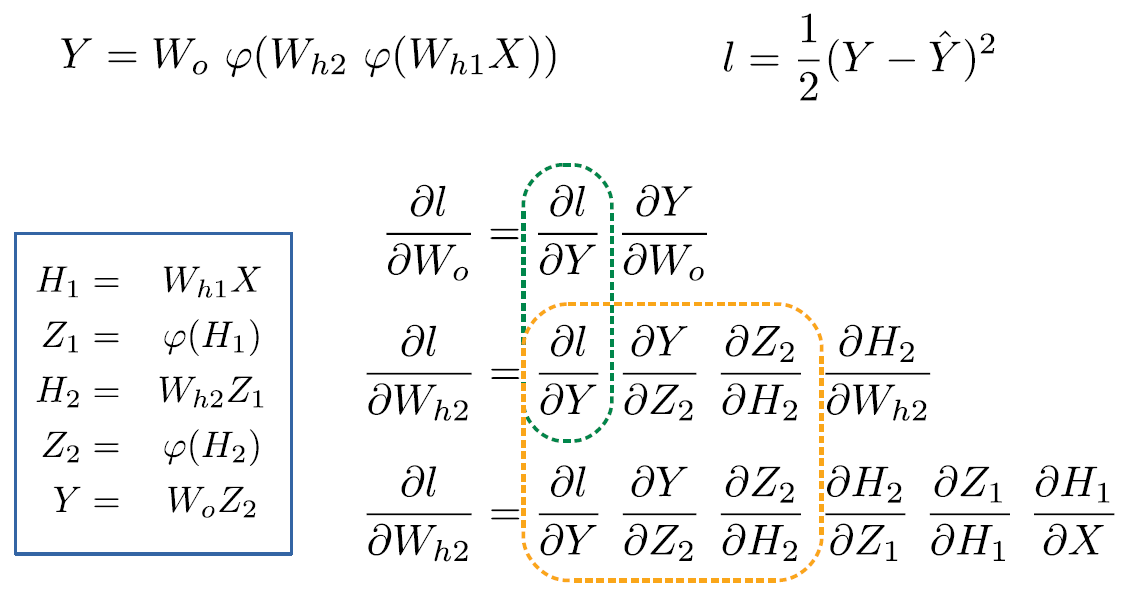

Doing the math, you have the following gradients. We define the variables $D_n$ to have a reference for the code below.

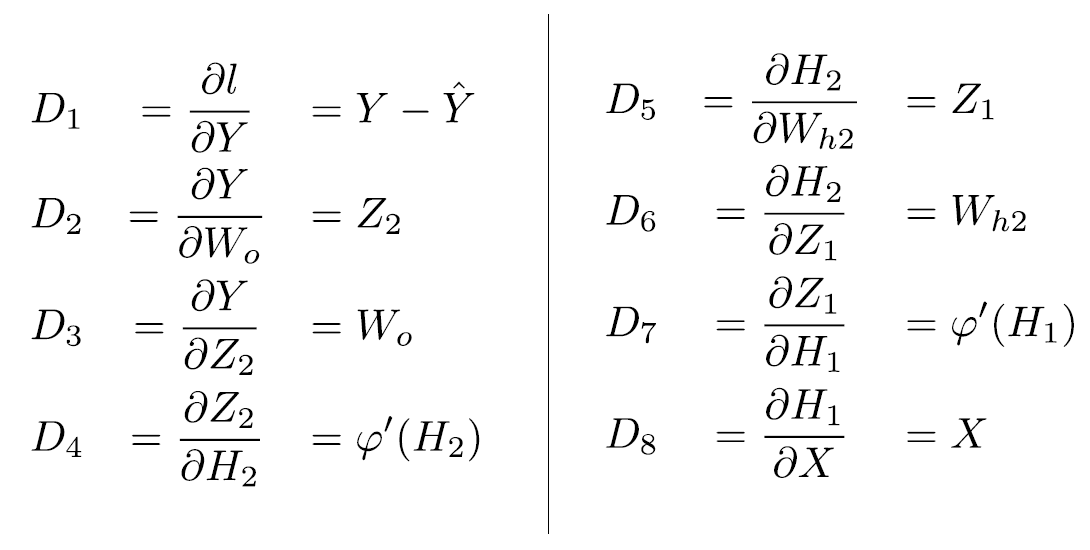

## Activation Functions

There are several non-linear activation function that can be used, each of which has specific properties and tackles specific issues. Here some examples:

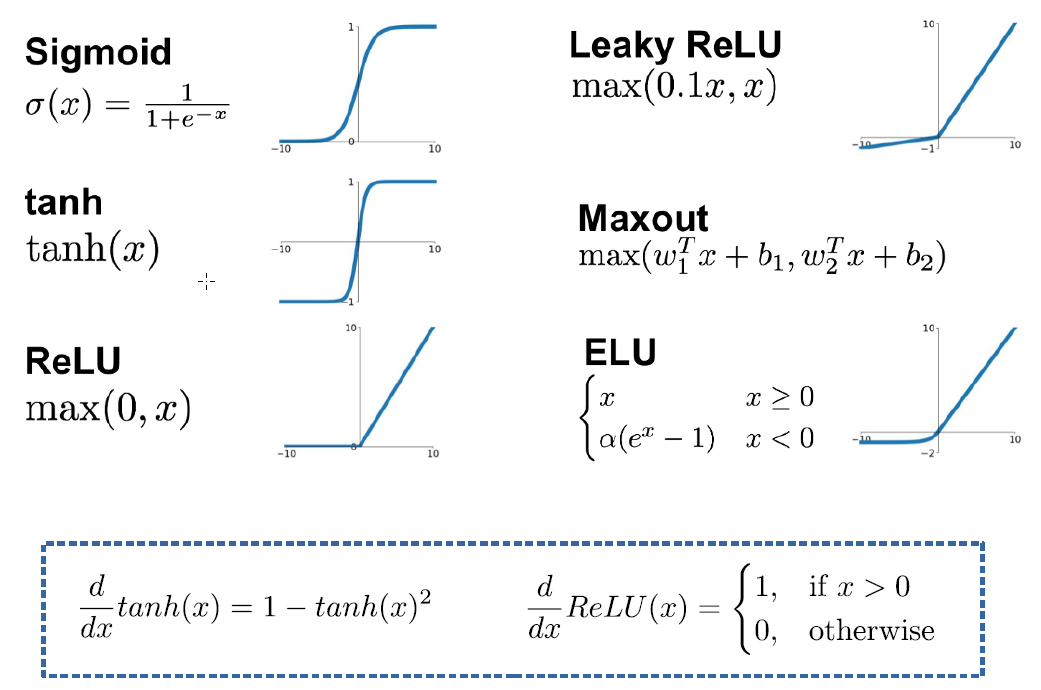

# Generate training and test data

Let's define the same model used for the OLS implementation of the previous labs.

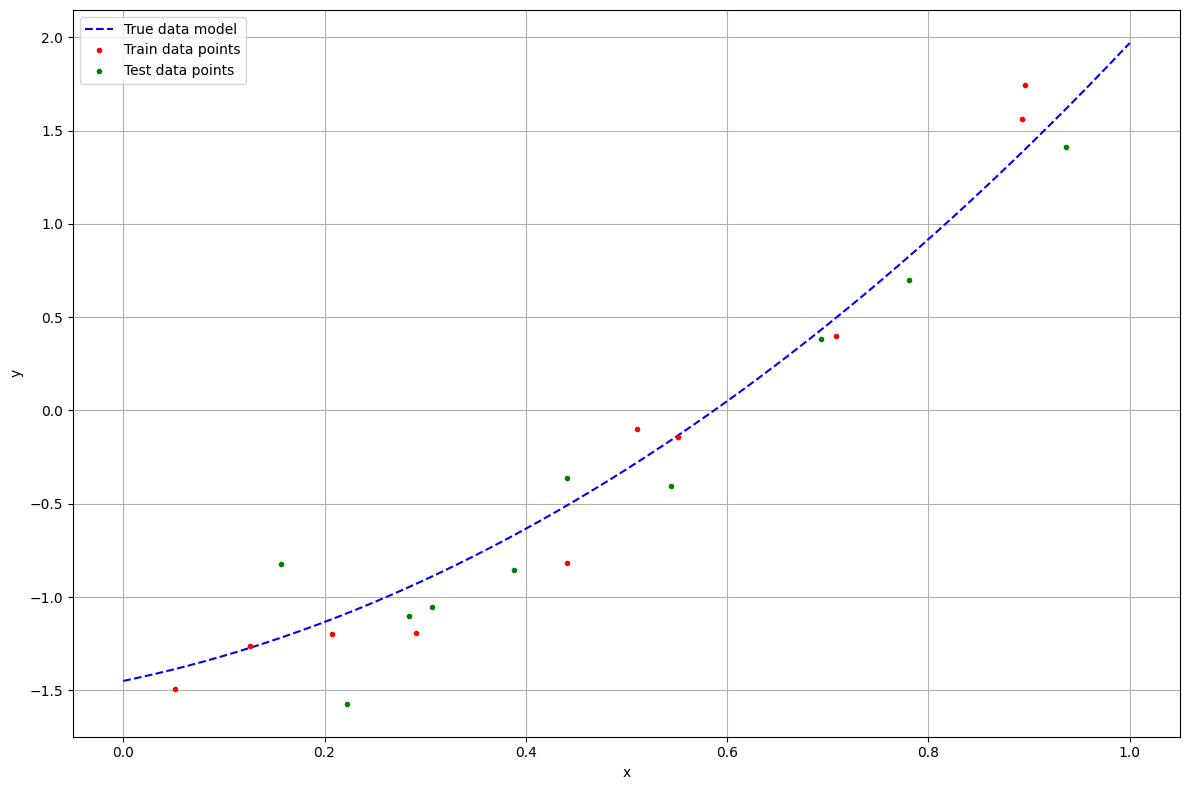

In [2]:
# Set random seed
np.random.seed(3)

### Define a simple quadratic model
# y = a + b * x + c * x^2
# a = -1.45, b = 1.12, c = 2.3

def poly_model(x, beta, noise_std=0):
    """
    INPUT
        x: x vector
        beta: polynomial parameters
        noise_std: enable noisy sampling (gaussian noise, zero mean, noise_std std)
    """
    pol_order = len(beta)
    x_matrix = np.array([x**i for i in range(pol_order)]).transpose()
    y = np.matmul(x_matrix, beta)
    noise = np.random.randn(len(y)) * noise_std
    return y + noise

### True parameter values
beta_true = [-1.45, 1.12, 2.3]

### Set random seed
np.random.seed(3)

### Generate 10 train points
num_train_points = 10
x_train = np.random.rand(num_train_points)
y_train = poly_model(x_train, beta_true, noise_std=0.2)

### Generate 10 test points
num_test_points = 10
x_test = np.random.rand(num_test_points)
y_test = poly_model(x_test, beta_true, noise_std=0.2)

### Plot
plt.figure(figsize=(12,8))
x_highres = np.linspace(0,1,1000)
plt.plot(x_highres, poly_model(x_highres, beta_true), color='b', ls='--', label='True data model')
plt.plot(x_train, y_train, color='r', ls='', marker='.', label='Train data points')
plt.plot(x_test, y_test, color='g', ls='', marker='.', label='Test data points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Activation function

Let's define the activation function *act* and its dervivative *act_der*. We consider a **sigmoid** activation function, which is available in the *scipy* python package in the *scipy.special* module named as *expit*.

Fortunately, the derivative of the sigmoid $\sigma(x)$ is quite simple:

$$
\sigma(x) = \frac{1}{1+e^{-x}}\\
\frac{d\sigma}{dx} = \sigma(x) * (1 - \sigma(x))
$$


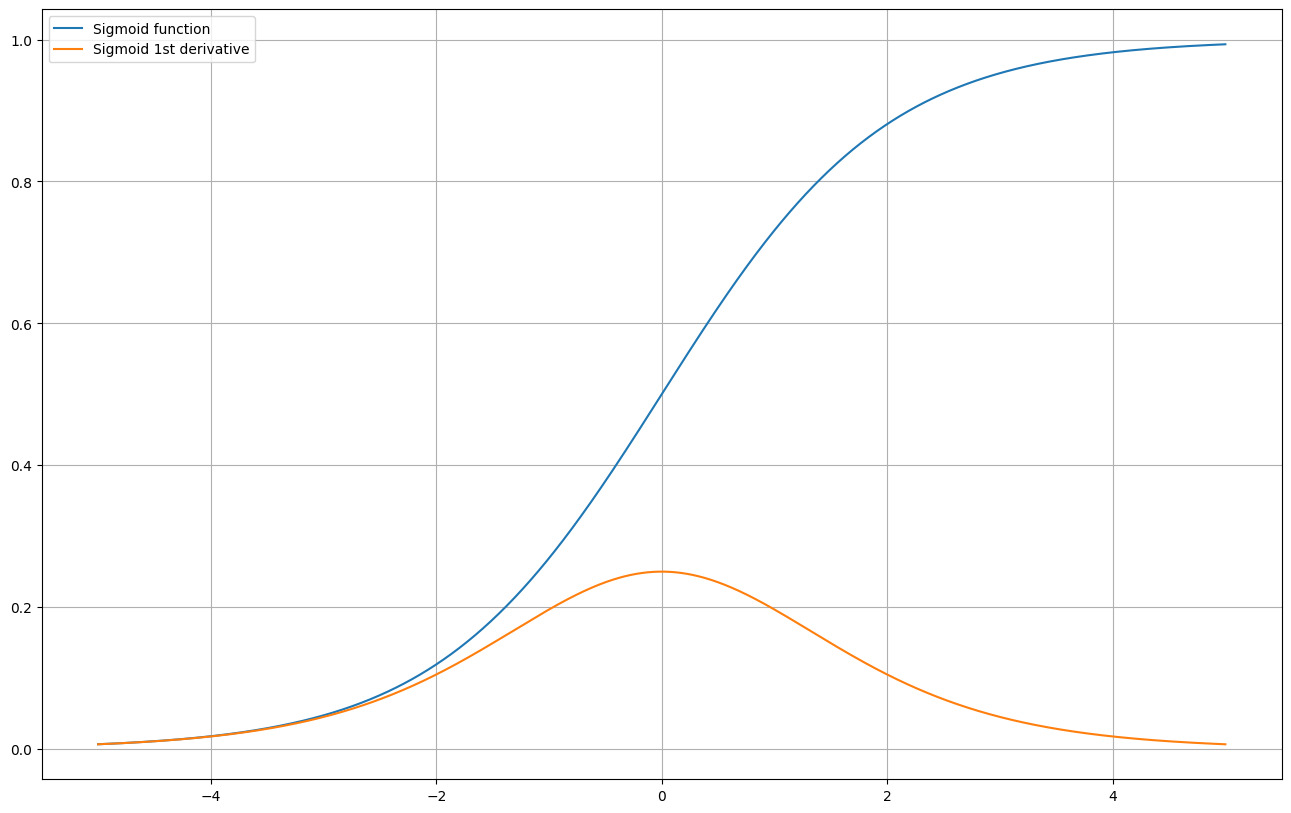

In [3]:
# Define activation function
from scipy.special import expit
##################################
#PUT YOUR CODE HERE
act = expit
# 1st derivative
act_der = lambda x: act(x) * (1 - act(x))
##################################

# Plot activation function
x_plot = np.linspace(-5,5,1000)
y_act = act(x_plot)
y_act_der = act_der(x_plot)

plt.figure(figsize=(16,10))
plt.plot(x_plot, y_act, label='Sigmoid function')
plt.plot(x_plot, y_act_der, label='Sigmoid 1st derivative')
plt.legend()
plt.grid()
plt.show()

# Network definition

Let's define the entire network using a class. We are implementing a fully connected feed-forward network with 2 hidden layers. The class has the following structure:
```
class Network():
    
    def __init__(self, Ni, Nh1, Nh2, No):
        [...]
    
    def forward(self, x, additional_out=False):
        [...]
    
    def update(self, x, label, lr):
        [...]
    
    def plot_weights(self):
        [...]
    
```


*   **\_\_init\_\_ method** - Here we initialize all the parameters (weights and biases) of the network. It requires the number of inputs ($N_i$) and outputs ($N_o$) and the number of neurons in the hidden layers ($N_h1$ and $N_h2$). The weights are initialized randomly, following the procedure proposed by Xavier et al. i.e. they are initialized with uniform distribution from $$\mathcal{U}(-0.5, 0.5)*\sqrt{\frac{12}{N_i + N_o}}$$
 The biases are initialized to zero.
*   **forward** - Evaluate the output of the network given an input $x$. If the *additional_out* parameter is True, it also outputs the activations of the secon hidden layer $Z_2$, for visualization.
* **update** - Given a training sample (*x* and *label*), evaluate all the gradients and perform the update of the weigths with a learning rate *lr*.
* **plot_weights** - Utility function to plot all the weights of the network.



(10, 128)
[[ 3.71334312e-01 -4.94248382e-01 -3.47981111e-01 ... -2.82672001e-01
  -3.22625591e-01 -4.86507462e-02]
 [ 2.42626617e-04 -4.14346629e-01  2.34111148e-01 ... -1.32758791e-01
   7.47575066e-02  1.87028221e-01]
 [-6.48238145e-02 -2.42265135e-01  2.15976723e-02 ... -2.66315224e-02
  -3.56523394e-01  4.10632203e-01]
 ...
 [-1.32268468e-01 -5.16631166e-03 -3.78009034e-01 ...  2.10386124e-01
  -2.81717216e-02  2.44732822e-01]
 [ 3.66453707e-01 -3.84347080e-02  3.29105150e-01 ...  8.16006617e-02
  -3.76366590e-01 -1.25167083e-01]
 [ 3.26545419e-02  1.59871591e-01 -9.59977549e-02 ... -7.12300559e-02
   3.69576431e-01 -2.57796340e-01]]


(128, 10)
[[-0.23964681 -0.18849137 -0.09746739 ... -0.32147726 -0.28403456
  -0.19460409]
 [-0.07396849 -0.12018704  0.04827965 ...  0.48257651 -0.47629356
   0.34396971]
 [-0.34318925  0.04592561  0.27235666 ... -0.12626653  0.4627048
   0.25935604]
 ...
 [-0.45768785  0.26940729 -0.07400359 ... -0.03967304  0.3977747
   0.16331446]
 [-0.46331039  

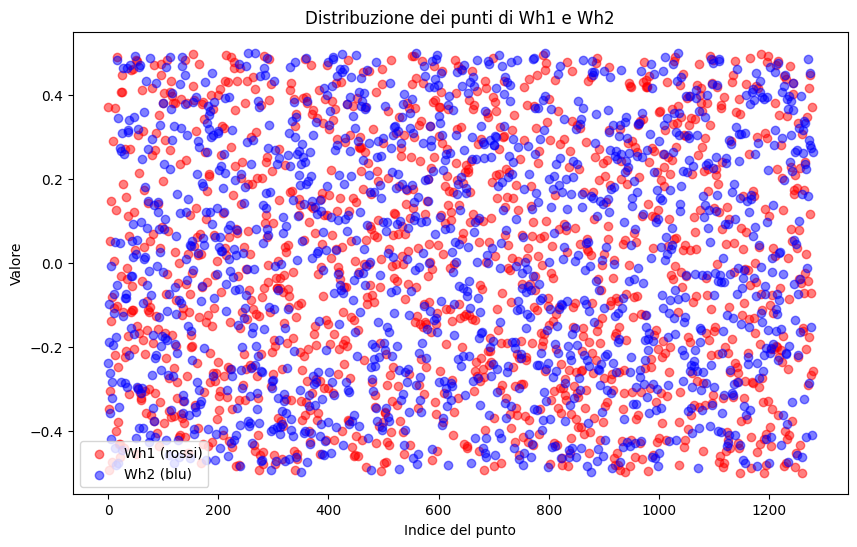

In [4]:
###QUI HO CREATO QUESTO CODICE PER VERICARE SE I DUE METODI DI GENERAZIONE RANDOMICA SONO EFFETTIVAMENTE UGUALI###
Ni = 10
Nh1 = 128
Wh1 = np.random.uniform(-0.5, 0.5, (Ni,Nh1))
Wh2 =  np.random.rand(Nh1,Ni) -0.5

#Wh1 = Wh1.T
print(Wh1.shape)
print(Wh1)
print("\n")
print (Wh2.shape)
print(Wh2)

x1 = np.arange(Wh1.size)
y1 = Wh1.flatten()  # Appiattiamo la matrice per ottenere i valori come un array

# Punti di Wh2
x2 = np.arange(Wh2.size)
y2 = Wh2.flatten()  # Appiattiamo anche Wh2

# Creazione della figura
plt.figure(figsize=(10, 6))
plt.scatter(x1, y1, color='red', label='Wh1 (rossi)', alpha=0.5)
plt.scatter(x2, y2, color='blue', label='Wh2 (blu)', alpha=0.5)

# Aggiungi etichette e legenda
plt.xlabel('Indice del punto')
plt.ylabel('Valore')
plt.legend()
plt.title('Distribuzione dei punti di Wh1 e Wh2')

# Mostra la figura
plt.show()

In [5]:
class Network():

    def __init__(self, Ni, Nh1, Nh2, No):

        ### WEIGHT INITIALIZATION (Xavier)
        # Initialize hidden weights and biases (layer 1)
        Wh1 = (np.random.rand(Nh1, Ni) -0.5) * np.sqrt(12 / (Ni + Nh1))  #####L'ORDINE è INVERTITO PERCHè LA MATRICE è PREMOLTIPLICATA
        Bh1 = np.zeros([Nh1, 1])
        self.WBh1 = np.concatenate([Wh1, Bh1], 1) # Weight matrix including biases
        # Initialize hidden weights and biases (layer 2)
        Wh2 = (np.random.rand(Nh2, Nh1) -0.5) * np.sqrt(12 / (Nh2 + Nh1))
        Bh2 = np.zeros([Nh2, 1])
        self.WBh2 = np.concatenate([Wh2, Bh2], 1) # Weight matrix including biases
        # Initialize output weights and biases
        Wo = (np.random.rand(No, Nh2) -0.5) * np.sqrt(12 / (No + Nh2))
        Bo = np.zeros([No, 1])
        self.WBo = np.concatenate([Wo, Bo], 1) # Weight matrix including biases

        ### ACTIVATION FUNCTION
        self.act = expit
        self.act_der = lambda x: act(x) * (1 - act(x))

    def forward(self, x, additional_out=False):

        # Convert to numpy array
        x = np.array(x)

        ### Hidden layer 1
        # Add bias term (remember homogeneous coordinates i.e. append a 1 at the end)
        X = np.append(x, 1)
        # Forward pass (linear)
        H1 = self.WBh1 @ X   ###np.mathmul(self.WBh1, X)
        # Activation function
        Z1 = self.act(H1)

        ### Hidden layer 2
        # Add bias term (remember homogeneous coordinates i.e. append a 1 at the end)
        Z1 = np.append(Z1, 1)
        # Forward pass (linear)
        H2 = self.WBh2 @ Z1
        # Activation function
        Z2 = self.act(H2)

        ### Output layer
        # Add bias term (remember homogeneous coordinates i.e. append a 1 at the end)
        Z2 = np.append(Z2, 1)
        # Forward pass (linear)
        Y = self.WBo @ Z2
        # NO activation function

        if additional_out:
            return Y.squeeze(), Z2

        return Y.squeeze()

    def update(self, x, label, lr):

        # Convert to numpy array
        X = np.array(x)

       ### Hidden layer 1
        # Add bias term (remember homogeneous coordinates i.e. append a 1 at the end)
        X = np.append(X, 1)
        # Forward pass (linear)
        H1 = self.WBh1 @ X   ###np.mathmul(self.WBh1, X)
        # Activation function
        Z1 = self.act(H1)

        ### Hidden layer 2
        # Add bias term (remember homogeneous coordinates i.e. append a 1 at the end)
        Z1 = np.append(Z1, 1)
        # Forward pass (linear)
        H2 = self.WBh2 @ Z1
        # Activation function
        Z2 = self.act(H2)

        ### Output layer
        # Add bias term (remember homogeneous coordinates i.e. append a 1 at the end)
        Z2 = np.append(Z2, 1)
        # Forward pass (linear)
        Y = self.WBo @ Z2
        # NO activation function

        # Evaluate the derivative terms (remember that the biases are concatenated with the weights)
        D1 = Y - label
        D2 = Z2
        D3 = self.WBo[:, :-1]
        D4 = self.act_der(H2)
        D5 = Z1
        D6 = self.WBh2[:, :-1]
        D7 = self.act_der(H1)
        D8 = X

        # Layer Error (these are needed later to compte dWBo, dWBh2, dWBh1 as dWBo=Eo*D2, dWB2=Eh2*D5, dWB1=Eh1*D8)
        Eo = D1
        Eh2 = np.matmul(Eo, D3) * D4   ##### !!!!! QUA MOLTIPLICO ELEMENT WISE PERCHè D4 è UNA DERIVATA
        Eh1 = np.matmul(Eh2, D6) * D7


        # Derivative for weight matrices
        dWBo = np.matmul(Eo.reshape(-1, 1), D2.reshape(1, -1))
        dWBh2 = np.matmul(Eh2.reshape(-1, 1), D5.reshape(1, -1))
        dWBh1 = np.matmul(Eh1.reshape(-1, 1), D8.reshape(1, -1))

        # Update the weights
        self.WBh1 -= lr * dWBh1
        self.WBh2 -= lr * dWBh2
        self.WBo -= lr * dWBo

        # Evaluate loss function
        loss = D1**2 /2

        return loss

    def plot_weights(self):

        fig, axs = plt.subplots(3, 1, figsize=(12,6))
        axs[0].hist(self.WBh1.flatten(), 20)
        axs[1].hist(self.WBh2.flatten(), 50)
        axs[2].hist(self.WBo.flatten(), 20)
        plt.legend()
        plt.grid()
        plt.show()

Now we can instantiate the actual object.

1st hidden layer weigth matrix shape: (128, 2)
2nd hidden layer weigth matrix shape: (512, 129)
Output layer weigth matrix shape: (1, 513)


C:\Users\giuse\AppData\Local\Temp\ipykernel_15656\3783862196.py:121: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


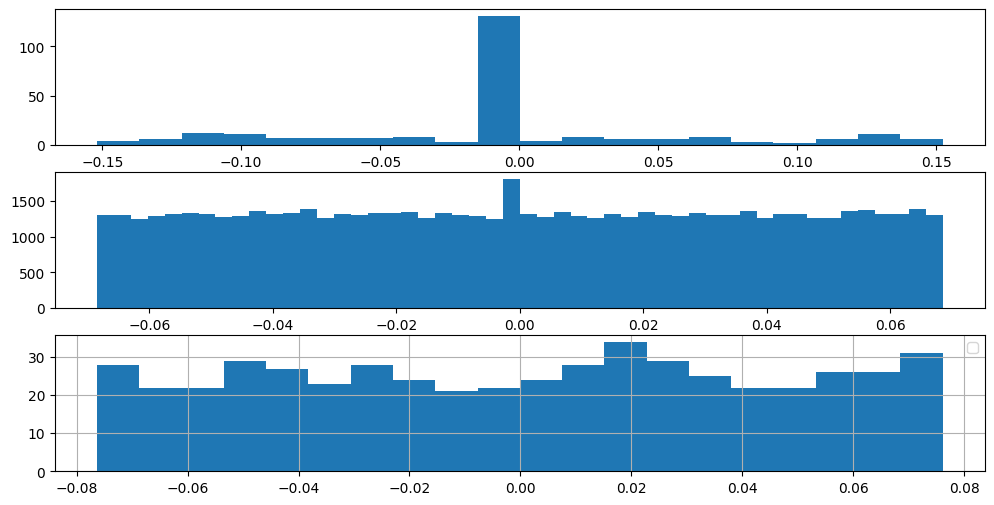

In [6]:
### PARAMETERS
Ni = 1 # Number of inputs
Nh1 = 128 # Number of hidden neurons (layer 1)
Nh2 = 512 # Number of hidden neurons (layer 2)
No = 1 # Number of outputs

### Initialize network
net = Network(Ni, Nh1, Nh2, No)

# Access the class members
print('1st hidden layer weigth matrix shape:', net.WBh1.shape)
print('2nd hidden layer weigth matrix shape:', net.WBh2.shape)
print('Output layer weigth matrix shape:', net.WBo.shape)

# Plot weights
plt.close('all')
net.plot_weights()

Let's check what is the output of the network just initialized, without having performed any training step.

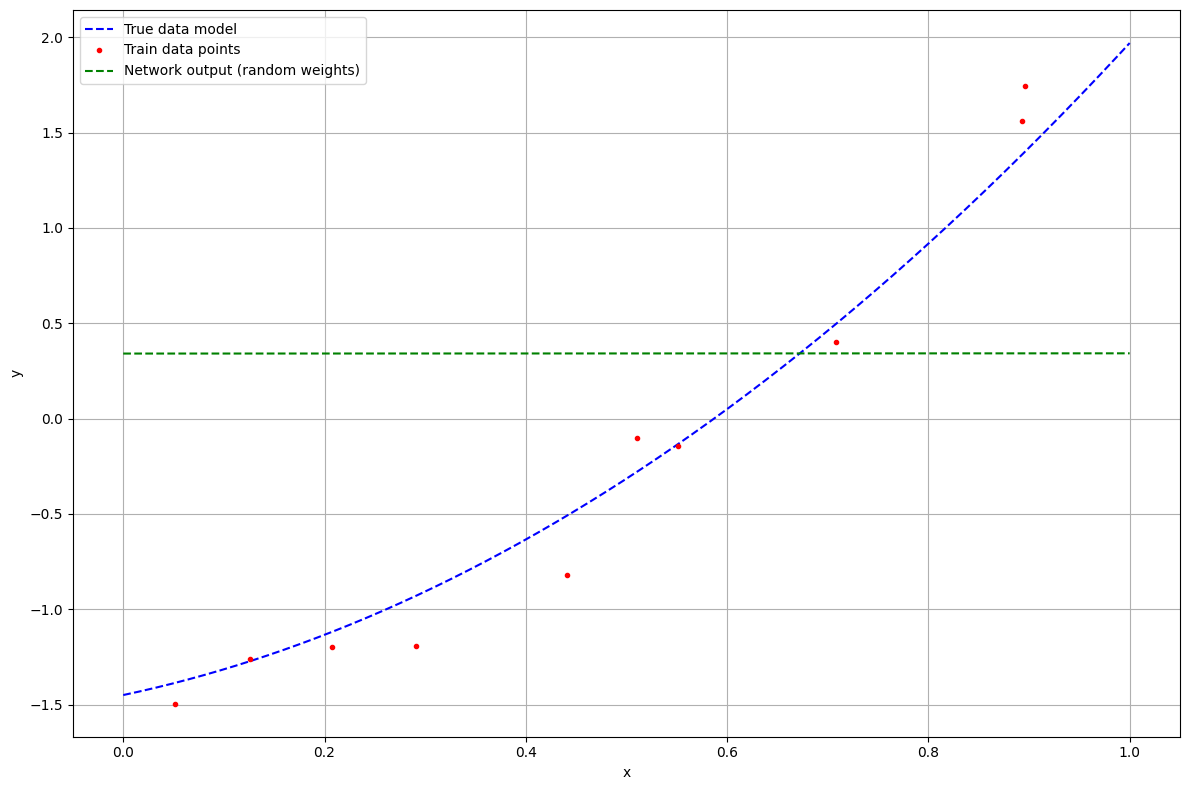

In [7]:
### FORWARD PASS (before training)
# Define the x vector
x_highres = np.linspace(0, 1, 1000)

# Evaluate the output for each input (this can be done as a batch, but for now let's do 1 input at a time)
initial_net_output = []
for x in x_highres:
    net_out = net.forward(x)
    initial_net_output.append(net_out)
initial_net_output = np.array(initial_net_output)

# Or in just 1 line of pythonic code!!
initial_net_output = np.array([net.forward(x) for x in x_highres])

### Plot
plt.close('all')
plt.figure(figsize=(12,8))
x_highres = np.linspace(0,1,1000)
plt.plot(x_highres, poly_model(x_highres, beta_true), color='b', ls='--', label='True data model')
plt.plot(x_train, y_train, color='r', ls='', marker='.', label='Train data points')
plt.plot(x_highres, initial_net_output, color='g', ls='--', label='Network output (random weights)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

As you can see, the output is just a random value. Let's train this network.

# Network training


Here, a **learning rate decay** can be optionally enabled, which decrease the learning rate from *lr* to *lr_final* during the training.

In [8]:
#%% TRAINING
num_epochs = 5000
lr = 1e-2
en_decay = False
lr_final = 1e-5
lr_decay = (lr_final / lr)**(1 / num_epochs)

train_loss_log = []
test_loss_log = []
for num_ep in range(num_epochs):
    # Learning rate decay
    if en_decay:
        lr *= lr_decay
    # Train single epoch (sample by sample, no batch for now)
    train_loss_vec = [net.update(x, y, lr) for x, y in zip(x_train, y_train)]
    avg_train_loss = np.mean(train_loss_vec)
    # Test network
    y_test_est = np.array([net.forward(x) for x in x_test])
    avg_test_loss = np.mean((y_test_est - y_test)**2/2)
    # Log
    train_loss_log.append(avg_train_loss)
    test_loss_log.append(avg_test_loss)
    print('Epoch %d - lr: %.5f - Train loss: %.5f - Test loss: %.5f' % (num_ep + 1, lr, avg_train_loss, avg_test_loss))



Epoch 1 - lr: 0.01000 - Train loss: 0.95814 - Test loss: 0.40070
Epoch 2 - lr: 0.01000 - Train loss: 0.91271 - Test loss: 0.40170
Epoch 3 - lr: 0.01000 - Train loss: 0.91012 - Test loss: 0.40271
Epoch 4 - lr: 0.01000 - Train loss: 0.90763 - Test loss: 0.40373
Epoch 5 - lr: 0.01000 - Train loss: 0.90523 - Test loss: 0.40476
Epoch 6 - lr: 0.01000 - Train loss: 0.90291 - Test loss: 0.40581
Epoch 7 - lr: 0.01000 - Train loss: 0.90068 - Test loss: 0.40686
Epoch 8 - lr: 0.01000 - Train loss: 0.89853 - Test loss: 0.40793
Epoch 9 - lr: 0.01000 - Train loss: 0.89645 - Test loss: 0.40900
Epoch 10 - lr: 0.01000 - Train loss: 0.89445 - Test loss: 0.41007
Epoch 11 - lr: 0.01000 - Train loss: 0.89251 - Test loss: 0.41116
Epoch 12 - lr: 0.01000 - Train loss: 0.89065 - Test loss: 0.41224
Epoch 13 - lr: 0.01000 - Train loss: 0.88884 - Test loss: 0.41333
Epoch 14 - lr: 0.01000 - Train loss: 0.88710 - Test loss: 0.41443
Epoch 15 - lr: 0.01000 - Train loss: 0.88542 - Test loss: 0.41552
Epoch 16 - lr: 0.01

Plot train and test loss during training

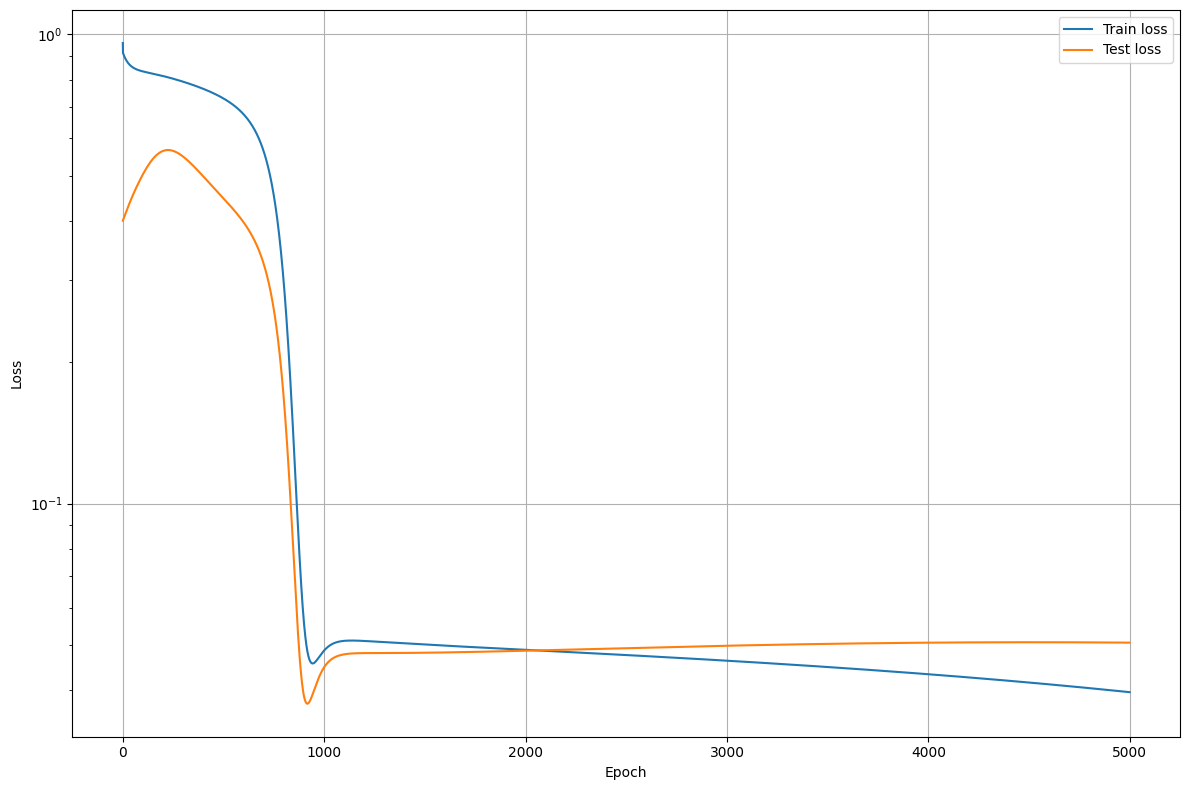

In [9]:
plt.close('all')
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(test_loss_log, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

Plot weights after training

C:\Users\giuse\AppData\Local\Temp\ipykernel_15656\3783862196.py:121: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


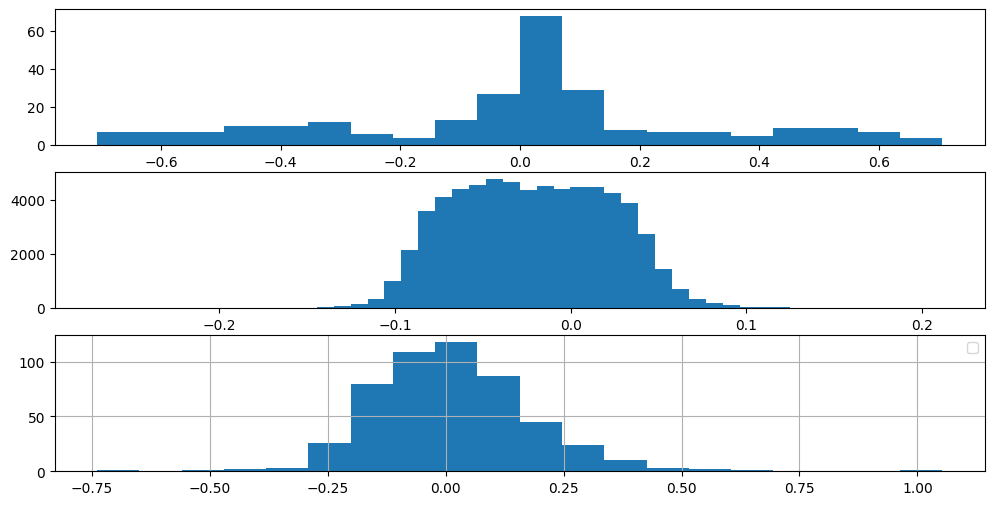

In [10]:
net.plot_weights()

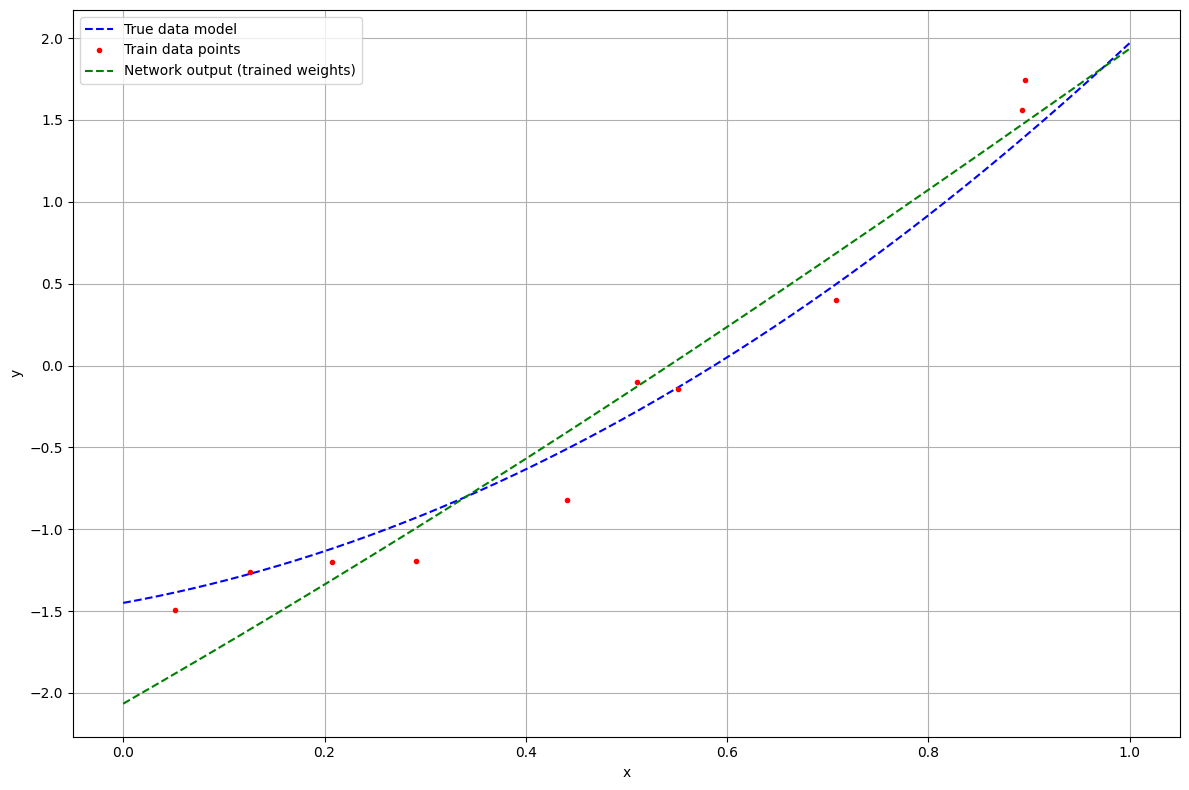

In [11]:
### FORWARD PASS (after training)
net_output = np.array([net.forward(x) for x in x_highres])

### Plot
plt.close('all')
plt.figure(figsize=(12,8))
x_highres = np.linspace(0,1,1000)
plt.plot(x_highres, poly_model(x_highres, beta_true), color='b', ls='--', label='True data model')
plt.plot(x_train, y_train, color='r', ls='', marker='.', label='Train data points')
plt.plot(x_highres, net_output, color='g', ls='--', label='Network output (trained weights)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

Now the output is better, but it can still be improved by a large margin. Try to improve it by changing the network structure and the training hyper-parameters, but remember: **THIS MUST BE DONE ON A VALIDATION SET!**

# Analyze activations

By enabling the *additional_out* parameter of the *forward* method, we can see the activations of the last layer for a given input. Let's try with 3 different input values: $x=0.1$, $x=0.9$ and $x=2.5$.


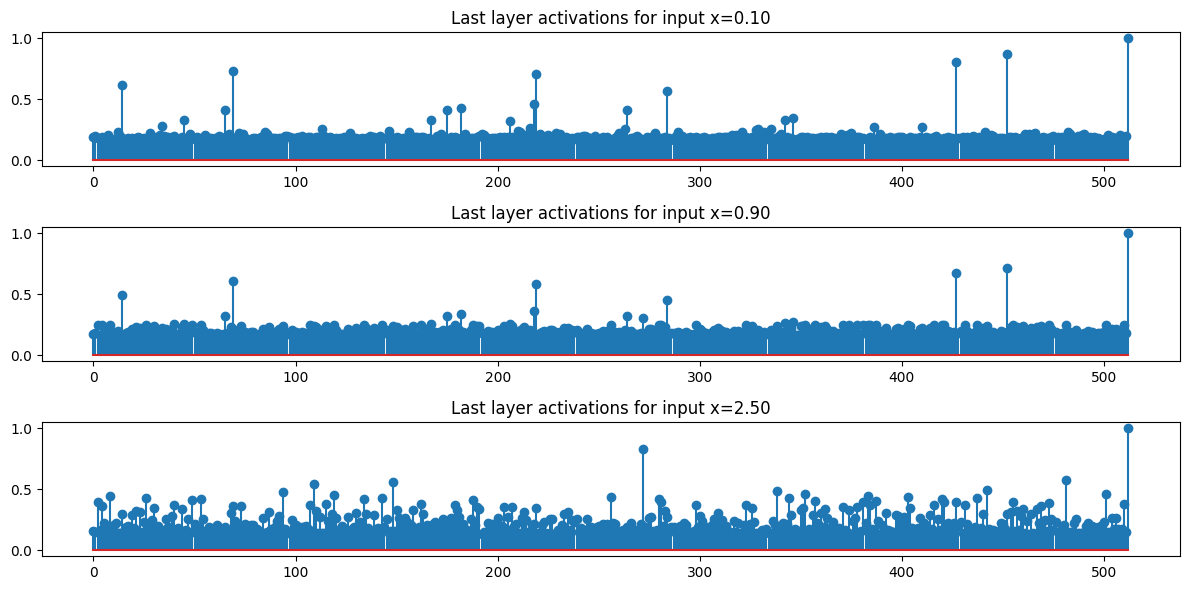

In [12]:
x1 = 0.1
y1, z1 = net.forward(x1, additional_out=True)
x2 = 0.9
y2, z2 = net.forward(x2, additional_out=True)
x3 = 2.5
y3, z3 = net.forward(x3, additional_out=True)

fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1)
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2)
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3)
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.show()

As you may have noticed, some neurons are contributing much more than the others. Maybe the number of neurons is too high? Try to make some changes and see what happens.

In the last case the input is $x=2.5$, far away from the training space $[0,1]$. The behavior of the network seems to be quite confused, maybe it is not generalizing very well, try to do some tests to check this hypothesis.